# Transformer Thermals

Datasheet: https://www.mag-inc.com/Media/Magnetics/Datasheets/0077726A7.pdf
<br>Digikey Website: https://www.digikey.ca/en/products/detail/magnetics-a-division-of-spang-co/0077726A7/18626757 

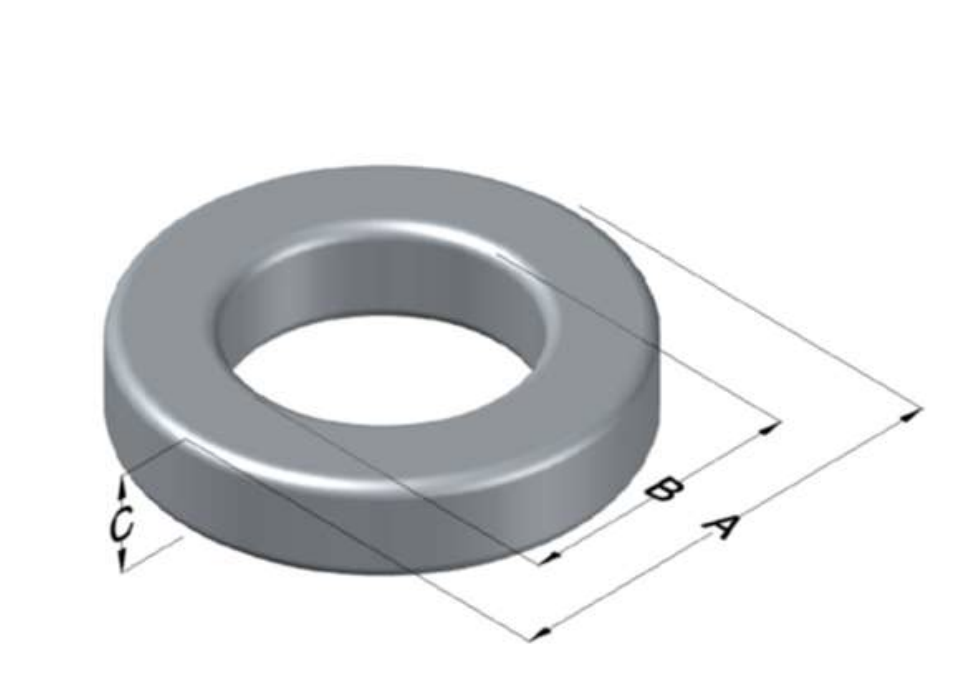

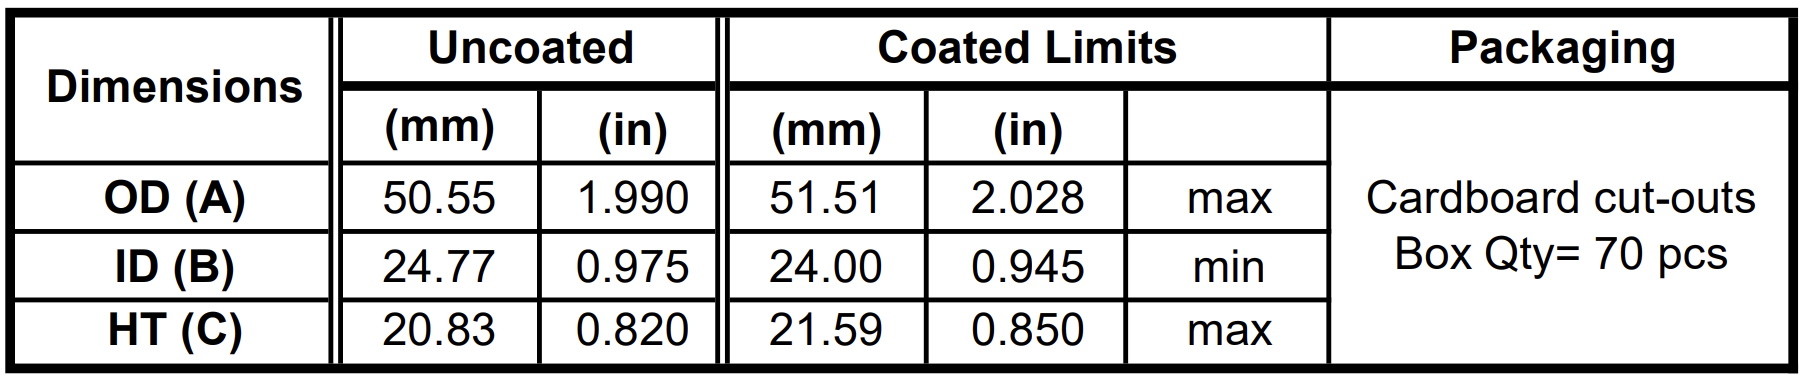

### Chosen Parameters:
* Primary: 32 turns
    * Current: 4.47 A
* Secondary: 6 turns
    * Current: 35 / sqrt(2) A ~= 25 A

**Wire parameters:**
* Material copper:
    * Resistivity: 1.68 * 10^-8 Ohm-m
    * Thermal conductivity: 398 W/mK
    * Density: 8.96 g/cm3
* Wire insulation:
    * Estimate of thermal conductivity: 0.7 W/mK
* Assumptions:
    * Length of one loop is just the circumference of the toroid

**Transformer Materials:**
* Material is called: Kool Mu
* Made of 85% iron, 9% silicon, 6% aluminum
* Cannot find information on Kool Mu, so will use this information on "typical ferrite materials":
    * https://www.mag-inc.com/Media/Magnetics/File-Library/Products/Ferrite/Magnetics-Ferrite-Materials-Web-8-17a.pdf 
    * Specific heat: 800 J/kgK
    * Thermal conductivity: 35 mW/cmC

### Need to find:
* What wire diameters can we use for both?

**Available Wire Parameters:**
* From this website, we have the following information: https://bulkwire.com/magnet-wire?srsltid=AfmBOoqdtwVvHc4ft0qBm-psgxOX-NotI8-EuaZrR1pw32hsuPsHYG04
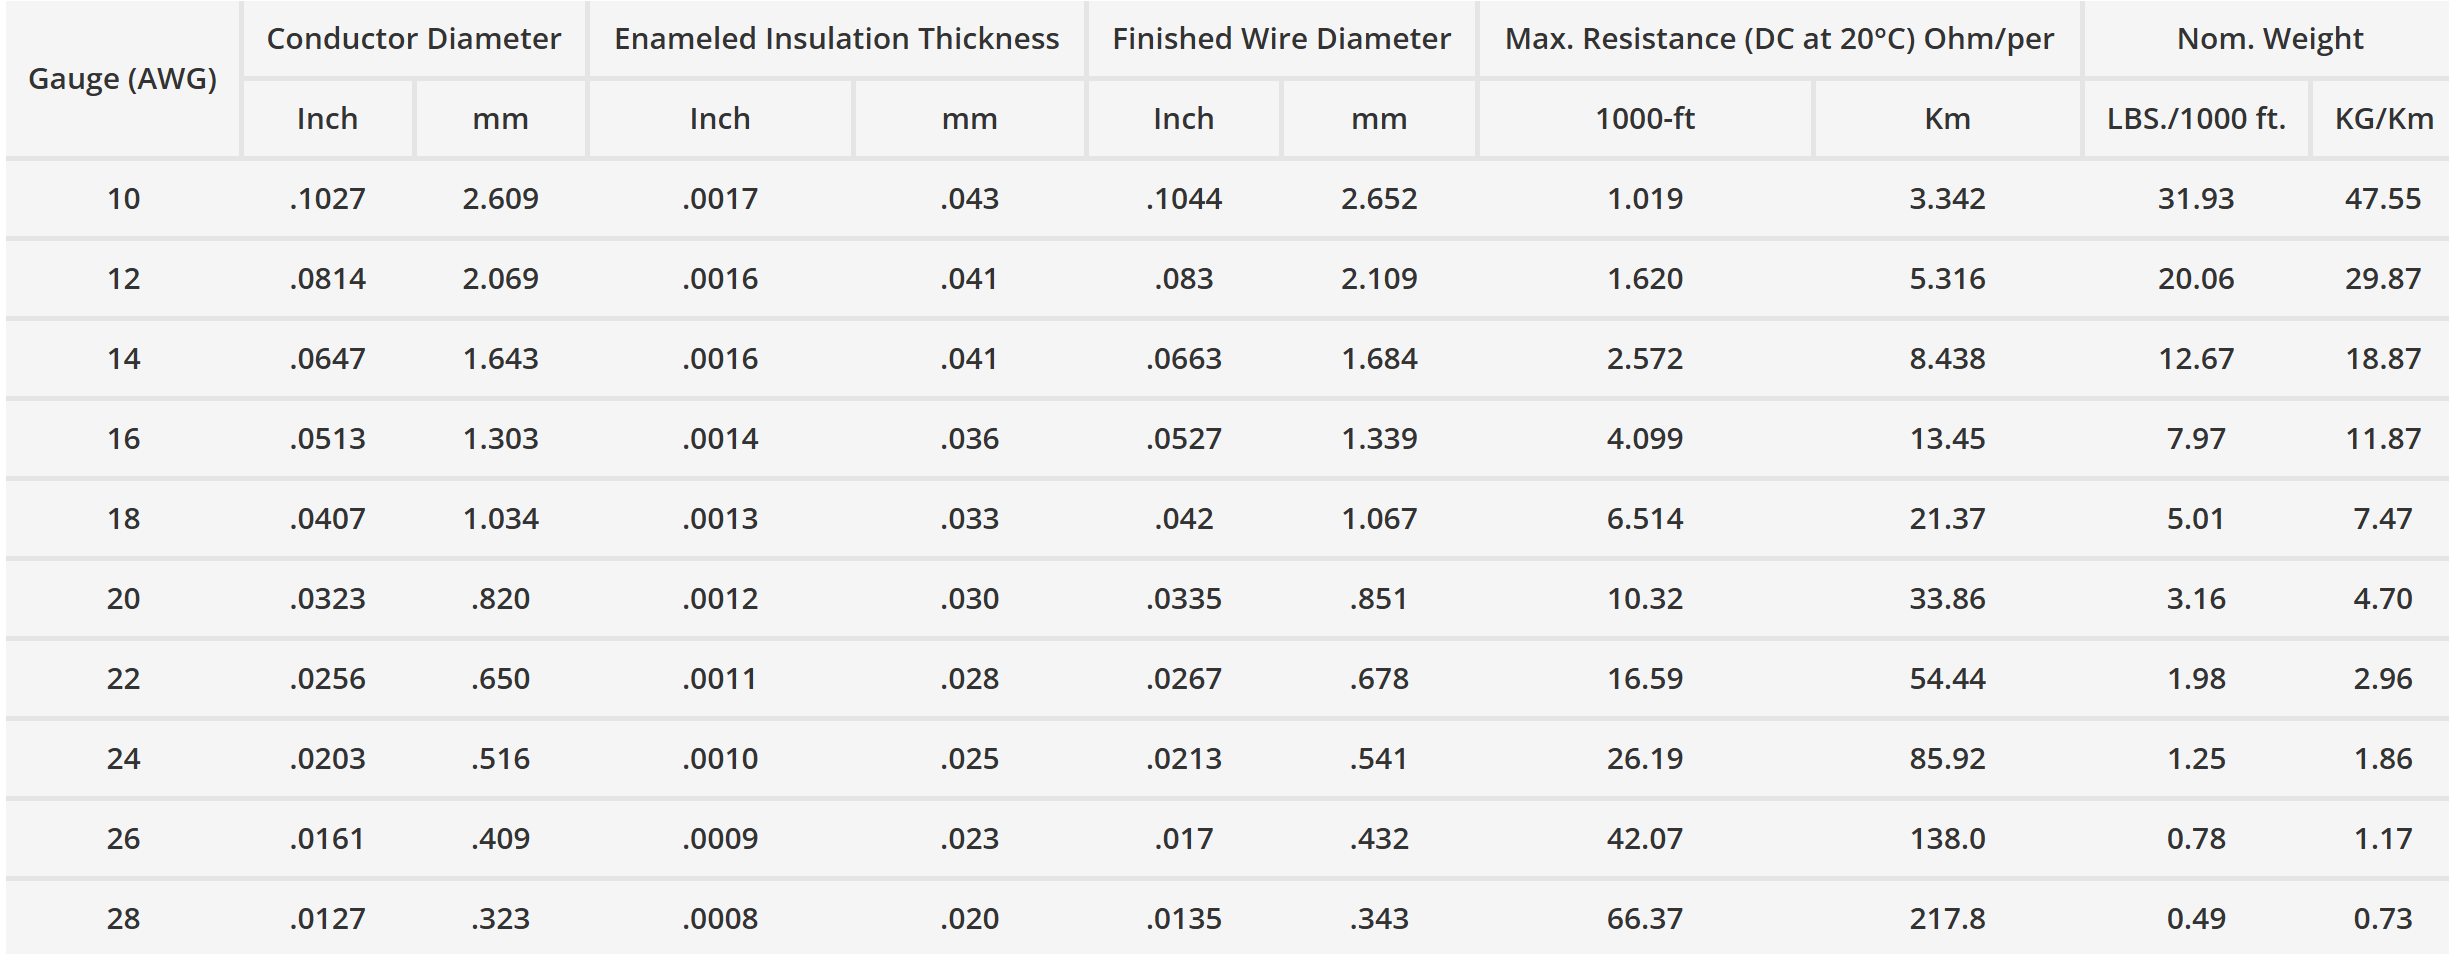

In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

#### Set up constants:

# Primary coil:
N_prim = 32             # Number of turns - primary coil
I_prim = 4.47           # A - primary coil RMS current

# Secondary coil:
N_sec = 6               # Number of turns - secondary coil
I_sec = 25              # A - secondary coil RMS current

# Transformer - Ferrite Core (fc) - Parameters:
mass_fc = 0.164         # kg - transformer core mass
Ax_fc = 262 / 1000**2   # m2 - cross sectional area
OD_fc = 51.51 / 1000    # m - coated outer diameter
ID_fc = 24 / 1000       # m - coated inner diameter
HT_fc = 21.59 / 1000    # m - coated height
As_fc = math.pi * HT_fc * (OD_fc + ID_fc) + math.pi/2 * (OD_fc**2 - ID_fc**2)
c_fc = 800              # J/kgK - specific heat of ferrite core
k_fc = 3.5              # W/mK - thermal conductivity

# # !!! DEBUGGING - to see if temperature increases with NO heat transfer out of the wires
# k_cu = 10**-15
# k_ins = 10**-15
# k_fc = 10**-15

wrap_perimeter = (OD_fc - ID_fc) + 2 * HT_fc    # m - toroid wire wrap perimeter for one turn
l_fc = (OD_fc - ID_fc) / 2                      # m - Assumed "length" of the core for thermal resistance calculations
R_th_fc = math.log(OD_fc / ID_fc) / (k_fc * 2 * math.pi * HT_fc)                 # K/W - thermal resistance of ferrite core - eqn 3.28

# Copper Wire Material Parameters
k_cu = 398                      # W/mk - thermal conductivity of copper
k_ins = 0.7                     # W/mk - thermal conducivity of wire insulation
c_cu = 385                      # J/kgK - specific heat capacity of copper
rho_m_cu = 8960                 # kg/m3 - mass density of copper

# Electrical Parameters
f_sw = 148 * 10**3              # Hz - maximum switching frequency
mu_cu = 1                       # Relative permeability of copper
rho_R_cu = 1.68 * 10**-8        # Ohm-m - resitivity of copper
mu_vac = 4 * math.pi * 10**-7   # H/m - permeability of a vacuum
s_cu = math.sqrt(rho_R_cu / (math.pi * f_sw * mu_cu * mu_vac))   # m - skin depth of copper

# !!!
h_air = 1                       # W/m2K - change to desired value
percent_conduction = 0.8        # Percent of wire mass contacting toroid for conductive heat transfer
T_air = 35                      # K - air ambient temperature

# Wire Parameters and class setup
class wire_params:
    # Class Item Definition
    def __init__(self, wire_type, I, N, j): ### !!! TEMPORARILY ADDED A "j" value
        # Calculate remaining wire parameters
        self.I = I                                              # A - expected current through wire
        self.N = N                                              # turns - number of required turns
        self.AWG = wire_type['Gauge'][j]
        self.D_cu = wire_type['D_cu'][j]                        # m - copper conductor diameter
        self.D_ins = wire_type['D_ins'][j]                      # m - total wire diameter including insulation
        self.Th_ins = wire_type['Th_ins'][j]                    # m - insulation thickness
        self.length = N * wrap_perimeter                        # m - total wire length
        self.Ax = math.pi / 4 * self.D_cu**2                    # m2 - cross sectional area of copper conductor
        self.mass = rho_m_cu * self.length * self.Ax            # kg - mass of copper conductor
        self.AxR = math.pi / 4 * (self.D_cu**2 - (self.D_cu - s_cu)**2)   # m2 - cross sectional area for electrical resistance calcc
        self.R = rho_R_cu * self.length / self.AxR              # Ohms - electrical resistance of copper conductor
        self.total_As = math.pi * self.D_ins * self.length      # m2 - total surface area
        self.cond_As = self.total_As * percent_conduction       # m2 - surface area for conduction
        self.conv_As = self.total_As * (1 - percent_conduction) # m2 - surface area for convection
        self.R_th = math.log(self.D_ins / self.D_cu) / (k_ins * self.cond_As)        # K/W - thermal resistance for conduction - Eqn 3.28

Wire Data and Information

Find all possible pairs of wire sizes for primary and secondary coil. However, secondary coil diameter must always be larger than the primary coil.

In [3]:
# Upload wire data
wire_data = pd.read_csv("Wire_Gauge_Data.csv", header=[0], skiprows=[1])    # skip the row with the units since I don't want to deal with that
wire_data = wire_data.iloc[::-1,:].reset_index(drop=True)                   # reverse rows and reset index

# Coil Parameters - just conductor and insulated conductor
D_cu = wire_data.loc[:,'Conductor Diameter'].to_numpy()
D_ins = wire_data.loc[:,'Finished Wire Diameter'].to_numpy()
Th_ins = wire_data.loc[:,'Enameled Insulation Thickness'].to_numpy()
Gauge = wire_data.loc[:, 'Gauge'].to_numpy()

# Set up empty arrays for all values:
    # D_cu = copper conductor diameter
    # D_ins = total wire diameter including insulation
    # Th_ins = insulation thickness

D_cu_1 = []
D_cu_2 = []
D_ins_1 = []
D_ins_2 = []
Th_ins_1 = []
Th_ins_2 = []
Gauge_1 = []
Gauge_2 = []

# Create combination arrays
num = len(D_cu)
for i in range(0, num):         # For the primary coil

    for j in range(i + 1, num): # For all larger values than the primary in the array
        D_cu_1.append(D_cu[i])
        D_cu_2.append(D_cu[j])

        D_ins_1.append(D_ins[i])
        D_ins_2.append(D_ins[j])

        Th_ins_1.append(Th_ins[i])
        Th_ins_2.append(Th_ins[j])

        Gauge_1.append(Gauge[i])
        Gauge_2.append(Gauge[j])

# Convert all outputs to numpy and convert from mm to m to keep units correct
D_cu_1 = np.array(D_cu_1) / 1000
D_cu_2 = np.array(D_cu_2) / 1000
D_ins_1 = np.array(D_ins_1) / 1000
D_ins_2 = np.array(D_ins_2) / 1000
Th_ins_1 = np.array(Th_ins_1) / 1000
Th_ins_2 = np.array(Th_ins_2) / 1000
Gauge_1 = np.array(Gauge_1)
Gauge_2 = np.array(Gauge_2)

# Set up dictionaries with primary and secondary coil information
temp_1 = [D_cu_1, D_ins_1, Th_ins_1, Gauge_1]
temp_2 = [D_cu_2, D_ins_2, Th_ins_2, Gauge_2]
keys = ['D_cu', 'D_ins', 'Th_ins', 'Gauge']

coil_prim = dict(zip(keys, temp_1))
coil_sec = dict(zip(keys, temp_2))

Calculate parameters for all wire combinations

In [4]:
# !!!!!!!
# i = 0       # TEMPORARY!! - for iterating through TIME
p = 44       # TEMPORARY!! - for iterating through SIZE OPTIONS

primary = wire_params(coil_prim, I_prim, N_prim, p)
secondary = wire_params(coil_sec, I_sec, N_sec, p)

attrs = vars(primary)
print("PRIMARY:")
print(', '.join("%s: %s" % item for item in attrs.items()))

attrs = vars(secondary)
print("SECONDARY:")
print(', '.join("%s: %s" % item for item in attrs.items()))

print("CORE:")
print("mass_fc: %.3f kg" % mass_fc)

PRIMARY:
I: 4.47, N: 32, AWG: 12, D_cu: 0.002069, D_ins: 0.002109, Th_ins: 4.1e-05, length: 2.26208, Ax: 3.3621018273434243e-06, mass: 0.06814387598230925, AxR: 5.285094272588461e-07, R: 0.07190589616746314, total_As: 0.014987680015836531, cond_As: 0.011990144012669226, conv_As: 0.0029975360031673057, R_th: 2.281457493397256
SECONDARY:
I: 25, N: 6, AWG: 10, D_cu: 0.0026089999999999998, D_ins: 0.0026520000000000003, Th_ins: 4.2999999999999995e-05, length: 0.42414, Ax: 5.346111835864985e-06, mass: 0.020316798871611422, AxR: 6.723421003127737e-07, R: 0.010598104739663322, total_As: 0.0035337239866641613, cond_As: 0.002826979189331329, conv_As: 0.0007067447973328321, R_th: 8.260744103871264
CORE:
mass_fc: 0.164 kg


Begin Thermal Calculations

In [5]:
# Conduct thermal simulation over time
dt = 0.1                # s - time step for simulation
total_time = 30 * 60    # s - equivalent to ~30 minutes
total_i = int(total_time / dt)

# Temperature lists for primary, secondary, and core
T_1 = np.array([T_air])   # K
T_2 = np.array([T_air])   # K
T_C = np.array([T_air])   # K
time = [0]              # s

# For loop across all times
# We will be solving for each of these variables over time using matrix algebra and then we will add them to the arrays above
# T_1_temp
# T_2_temp
# T_C_temp

for i in range(0, total_i):
    # Add for loop later
    T_coil_coeff = lambda coil : coil.mass * c_cu / dt + 1 / (coil.R_th + R_th_fc) + h_air * coil.conv_As
    T_core_coeff = lambda coil : -1 / (coil.R_th + R_th_fc)
    T_constant = lambda coil, T0: coil.I**2 * coil.R + coil.mass * c_cu / dt * T0 + h_air * coil.conv_As * T_air

    # Set up equation 1:
    T_1_coeff = T_coil_coeff(primary)
    T_1_core = T_core_coeff(primary)
    T_1_constant = T_constant(primary, T_1[i])

    # Set up for equation 2:
    T_2_coeff = T_coil_coeff(secondary)
    T_2_core = T_core_coeff(secondary)
    T_2_constant  = T_constant(secondary, T_2[i])

    # Set up for equation 3:
    T_C_coeff = 1 / (primary.R_th + R_th_fc) + 1 / (secondary.R_th + R_th_fc) + mass_fc * c_fc / dt + h_air * As_fc
    T_C_1_coeff = -1 / (primary.R_th + R_th_fc)
    T_C_2_coeff = -1 / (secondary.R_th + R_th_fc)
    T_C_constant = mass_fc * c_fc / dt * T_C[i] + h_air * As_fc * T_air

    # Create matrix to solve
    solving_matrix = np.array([[T_1_coeff, 0, T_1_core],
                            [0, T_2_coeff, T_2_core],
                            [T_C_1_coeff, T_C_2_coeff, T_C_coeff]])
    solving_vector = np.array([[T_1_constant],
                            [T_2_constant],
                            [T_C_constant]])

    # Solve:
    result = np.linalg.solve(solving_matrix, solving_vector)

    # Save results to new temperature arrays
    T_1 = np.append(T_1, result[0])
    T_2 = np.append(T_2, result[1])
    T_C = np.append(T_C, result[2])
    time.append(time[i] + dt)

T_1

array([ 35.        ,  35.00547094,  35.01093649, ..., 114.54062136,
       114.5448779 , 114.54913442])

In [6]:
# # Conduct thermal simulation over time
# dt = 0.1                # s - time step for simulation
# total_time = 30 * 60    # s - equivalent to ~30 minutes
# total_i = int(total_time / dt)

# # Temperature lists for primary, secondary, and core
# T_1 = np.array([T_air])   # K
# T_2 = np.array([T_air])   # K
# T_C = np.array([T_air])   # K
# Qgen = np.array([0])
# time = [0]              # s

# # For loop across all times
# # We will be solving for each of these variables over time using matrix algebra and then we will add them to the arrays above
# # T_1_temp
# # T_2_temp
# # T_C_temp

# for i in range(0, total_i):
#     # Add for loop later
#     T_coil_coeff = lambda coil : coil.mass * c_cu / dt
#     T_constant = lambda coil, T0_coil, T0_core: coil.I**2 * coil.R + h_air * coil.conv_As * T_air\
#                                                 + T0_coil * (coil.mass * c_cu / dt - (1 / (coil.R_th + R_th_fc) + h_air * coil.conv_As))\
#                                                 + T0_core * 1 / (coil.R_th + R_th_fc)

#     # Set up equation 1:
#     T_1_coeff = T_coil_coeff(primary)
#     T_1_constant = T_constant(primary, T_1[i], T_C[i])

#     # Set up for equation 2:
#     T_2_coeff = T_coil_coeff(secondary)
#     T_2_constant  = T_constant(secondary, T_2[i], T_C[i])

#     # Set up for equation 3:
#     T_C_coeff = mass_fc * c_fc / dt
#     T_C_1_coeff = -1 / (primary.R_th + R_th_fc)
#     T_C_2_coeff = -1 / (secondary.R_th + R_th_fc)
#     T_C_constant = h_air * As_fc * T_air\
#                     + T_C[i] * (mass_fc * c_fc / dt - (1 / (primary.R_th + R_th_fc) + 1 / (secondary.R_th + R_th_fc) + h_air * As_fc))\
#                     - T_1[i] * T_C_1_coeff\
#                     - T_2[i] * T_C_2_coeff

#     # Create matrix to solve
#     solving_matrix = np.array([[T_1_coeff, 0, 0],
#                             [0, T_2_coeff, 0],
#                             [0, 0, T_C_coeff]])
#     solving_vector = np.array([[T_1_constant],
#                             [T_2_constant],
#                             [T_C_constant]])

#     # Solve:
#     result = np.linalg.solve(solving_matrix, solving_vector)

#     # Save results to new temperature arrays
#     T_1 = np.append(T_1, result[0])
#     T_2 = np.append(T_2, result[1])
#     T_C = np.append(T_C, result[2])
#     time.append(time[i] + dt)
#     Qgen = np.append(Qgen, primary.I**2 * primary.R + secondary.I**2 + secondary.R)

# T_1

Checked - linear algebra method or not, we get the same result

Plot results

Text(0, 0.5, 'Temperature (C)')

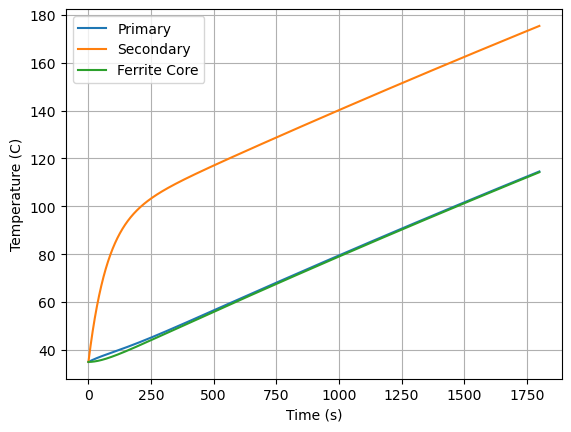

In [8]:
# convert time to array for ease of use
time = np.array(time)

# plot results
plt.plot(time, T_1, label='Primary')
plt.plot(time, T_2, label="Secondary")
plt.plot(time, T_C, label="Ferrite Core")
plt.legend()
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (C)")
# plt.plot(time, Qgen)